In [664]:
import os
import numpy as np
import skimage as sk
import skimage.io as skio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.transform import resize
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [665]:
def load_data(root_dir, start, end, type="Training"):
    data, label = [], []

    for i in range(start, end + 1):
        gender = "m"
        name = root_dir + "{:02d}-1{}.asf".format(i, gender)
        if not os.path.exists(name):
            gender = "f"

        for j in range(1, 7):
            path = root_dir + "{:02d}-{:d}{}".format(i, j, gender)

            # jpg
            img = skio.imread(path + ".jpg", as_gray=True)
            img = resize(img, (60, 80), anti_aliasing=True)
            img = img.astype(np.float32) - 0.5

            # the nose keypoint
            asf_file = open(path + ".asf")
            points = asf_file.readlines()[16:74]
            landmark = []
            for point in points:
                x, y = point.split("\t")[2:4]
                landmark.append([float(x), float(y)])
            nose_keypoint = np.array(landmark).astype("float32")[-6]

            data.append(img)
            label.append(nose_keypoint)

    data = torch.from_numpy(np.array(data))
    label = torch.from_numpy(np.array(label))
    print(f"{type} data done.")
    return data, label


In [666]:
root_dir = "imm_face_db/"

x_train, y_train = load_data(root_dir, 1, 32)
x_test, y_test = load_data(root_dir, 33, 40, "Testing")

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)


Training data done.
Testing data done.


In [675]:
# CNN model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.fc1 = nn.Linear(32 * 3 * 5, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [676]:
def fit_model(model, loss_func, optimizer, input_shape, epochs, train, test):
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        train_loss_per_epoch = []
        val_loss_per_epoch = []
        for inputs, labels in train:
            inputs = Variable(inputs.view(input_shape))

            # zero the gradients
            optimizer.zero_grad()

            # forward + backpropagation + optimize
            pred = model(inputs)
            loss = loss_func(pred, labels)
            loss.backward()
            optimizer.step()

            train_loss_per_epoch.append(loss.item())

        model.eval()
        for inputs, labels in test:
            inputs = Variable(inputs.view(input_shape))
            with torch.no_grad():
                pred = model(inputs)
                loss = loss_func(pred, labels)
                val_loss_per_epoch.append(loss.item())

        print(f"epoch: {epoch+1:{2}}/{epochs} - loss: {np.mean(train_loss_per_epoch):.6f} - val_loss: {np.mean(val_loss_per_epoch):.6f}")
        train_loss.append(np.mean(train_loss_per_epoch))
        val_loss.append(np.mean(val_loss_per_epoch))

    return train_loss, val_loss


In [677]:
def plot(train_loss, val_loss, epochs):
    plt.plot(range(epochs), train_loss)
    plt.plot(range(epochs), val_loss)
    plt.legend(["train", "val"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


In [678]:
# hyperparameters
learning_rate = 0.001
batch_size = 2
epochs = 25

# dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [679]:
# CNN
model = Model()
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()
input_shape = (-1, 1, 60, 80)


Model(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [680]:
train_loss, val_loss = fit_model(model, loss_func, optimizer, input_shape, epochs, train_loader, test_loader)


epoch:  1/25 - loss: 0.020572 - val_loss: 0.006019
epoch:  2/25 - loss: 0.004692 - val_loss: 0.005861
epoch:  3/25 - loss: 0.003721 - val_loss: 0.007805
epoch:  4/25 - loss: 0.003958 - val_loss: 0.007009
epoch:  5/25 - loss: 0.002988 - val_loss: 0.003769
epoch:  6/25 - loss: 0.001694 - val_loss: 0.004704
epoch:  7/25 - loss: 0.001827 - val_loss: 0.002251
epoch:  8/25 - loss: 0.001549 - val_loss: 0.001784
epoch:  9/25 - loss: 0.001891 - val_loss: 0.002815
epoch: 10/25 - loss: 0.001209 - val_loss: 0.002767
epoch: 11/25 - loss: 0.001320 - val_loss: 0.003979
epoch: 12/25 - loss: 0.001193 - val_loss: 0.003097
epoch: 13/25 - loss: 0.000814 - val_loss: 0.002012
epoch: 14/25 - loss: 0.000664 - val_loss: 0.001361
epoch: 15/25 - loss: 0.001008 - val_loss: 0.002928
epoch: 16/25 - loss: 0.000752 - val_loss: 0.002105
epoch: 17/25 - loss: 0.000747 - val_loss: 0.002143
epoch: 18/25 - loss: 0.000491 - val_loss: 0.001705
epoch: 19/25 - loss: 0.000468 - val_loss: 0.001599
epoch: 20/25 - loss: 0.000354 -

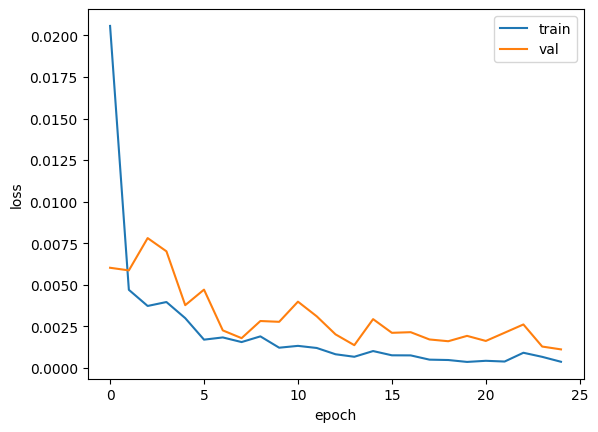

In [681]:
plot(train_loss, val_loss, epochs)


Best five


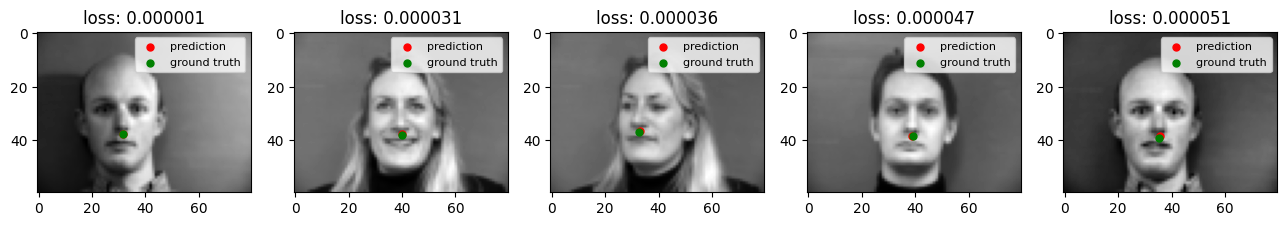

Worst five


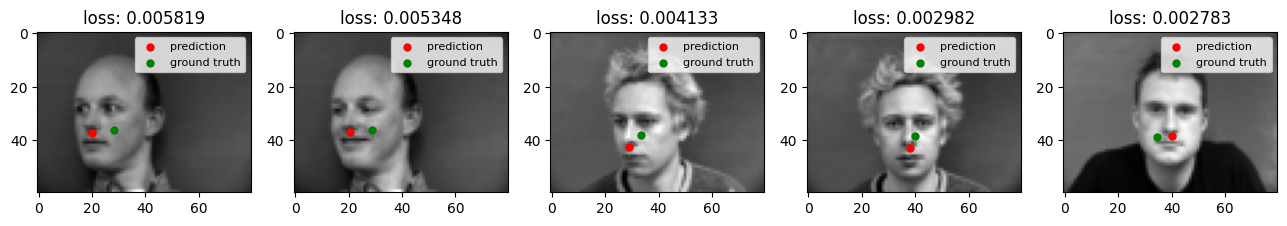

In [746]:
model.eval()

ranking = []
for inputs, labels in test:
    inputs = inputs.unsqueeze(0).unsqueeze(0)
    labels = labels.unsqueeze(0)

    with torch.no_grad():
        pred = model(inputs)
        loss = loss_func(pred, labels)

    pred = pred.detach().numpy()[0]
    labels = labels.numpy()[0]
    ranking.append([inputs[0][0].numpy(), labels, pred, loss])

ranking.sort(key=lambda x: x[3])

# best five
print("Best five")
plt.figure(figsize=(16, 12))
for i in range(5):
    arr = ranking[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(arr[0], cmap="gray")
    plt.scatter(arr[1][0] * 80, arr[1][1] * 60, s=25, c="red", label="prediction")
    plt.scatter(arr[2][0] * 80, arr[2][1] * 60, s=25, c="green", label="ground truth")
    plt.legend(fontsize=8)
    plt.title(f"loss: {arr[3]:.6f}")
plt.show()

# worst five
print("Worst five")
plt.figure(figsize=(16, 12))
for i in range(1, 6):
    arr = ranking[-i]
    plt.subplot(1, 5, i)
    plt.imshow(arr[0], cmap="gray")
    plt.scatter(arr[1][0] * 80, arr[1][1] * 60, s=25, c="red", label="prediction")
    plt.scatter(arr[2][0] * 80, arr[2][1] * 60, s=25, c="green", label="ground truth")
    plt.legend(fontsize=8)
    plt.title(f"loss: {arr[3]:.6f}")
plt.show()
